In [1]:
import pandas as pd
from My_model import My_model
from tqdm import tqdm
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据加载

In [2]:
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence
import pickle

# 载入Seqs字典和smiles2vec模型
sentence_model = word2vec.Word2Vec.load('updated_smi2vec_model.pkl')
file_path = 'seq_word_dict.pkl'
with open(file_path, 'rb') as f:
    seq_word_dict = pickle.load(f)
    seq_word_dict = seq_word_dict

In [3]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import random

# 加载datas数据
datas = torch.load('datas.pt')

# 固定随机种子以确保结果可复现
random.seed(42)

# 打乱数据
random.shuffle(datas)

# 设置训练集和测试集的比例
train_ratio = 0.9  # 90%的数据作为训练集
train_size = int(train_ratio * len(datas))

# 划分数据集
train_dataset = datas[:train_size]
test_dataset = datas[train_size:]

# 随机划分数据集
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 数据处理

In [4]:
from rdkit import Chem
from torch.nn.utils.rnn import pad_sequence
import mytools

word_num = len(seq_word_dict)
train_smi_padded_embeddings = []
train_seqs = []
for data in tqdm(train_loader, desc='训练数据处理中'):
    smi = data.smi
    mols = [Chem.MolFromSmiles(s) for s in smi]
    sentences = [mol2alt_sentence(m, 1) for m in mols]
    smi_embeddings = [torch.tensor(sentence_model.wv[s], dtype=torch.float32) for s in sentences]
    padded_embeddings = pad_sequence(smi_embeddings, batch_first=True)
    train_smi_padded_embeddings.append(padded_embeddings)
    seqs = [torch.tensor(mytools.split_sequence(s, 3, seq_word_dict), dtype=torch.long) for s in data.seq]
    train_seqs.append(seqs)

test_smi_padded_embeddings = []
test_seqs = []
for data in tqdm(test_loader, desc='测试数据处理中'):
    smi = data.smi
    mols = [Chem.MolFromSmiles(s) for s in smi]
    sentences = [mol2alt_sentence(m, 1) for m in mols]
    smi_embeddings = [torch.tensor(sentence_model.wv[s], dtype=torch.float32) for s in sentences]
    padded_embeddings = pad_sequence(smi_embeddings, batch_first=True)
    test_smi_padded_embeddings.append(padded_embeddings)
    seqs = [torch.tensor(mytools.split_sequence(s, 3, seq_word_dict), dtype=torch.long) for s in data.seq]
    test_seqs.append(seqs)

测试数据处理中: 100%|██████████| 68/68 [00:04<00:00, 16.59it/s]


# 模型导入、训练

In [9]:
import numpy as np
import csv
import torch
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings


# 模型加载
model = My_model(9, 16, 128, 300, len(seq_word_dict), 300, 128, heads=2).to(device)

# 定义损失函数，对于回归任务通常使用均方误差损失(MSEL)
criterion = torch.nn.MSELoss()

# 选择优化器，这里使用Adam，你可以根据需要调整学习率等参数
opti = torch.optim.Adam(model.parameters(), lr=1e-4)

# 忽略特定的警告
warnings.filterwarnings("ignore")

In [10]:
# CSV文件路径
metrics_csv_path = '/data/coding/metrics.csv'

# 定义CSV的列名
fieldnames = ['Epoch', 'Train_Loss', 'Val_Loss', 'Train_RMSE', 'Val_RMSE', 'Train_R2', 'Val_R2', 'Train_MAE', 'Val_MAE']

#设置训练次数epoch
num_epochs = 100
train_losses = []  # 用于存储每轮的训练损失
test_losses = []  # 用于存储每轮的测试损失
maes_train = []  # 用于存储每轮训练集的MAE
rmses_train = []  # 用于存储每轮训练集的RMSE
r2s_train = []  # 用于存储每轮训练集的R²
maes_test = []  # 用于存储每轮测试集的MAE
rmses_test = []  # 用于存储每轮测试集的RMSE
r2s_test = []  # 用于存储每轮测试集的R²

best_r2_val = -np.inf  # 初始化最佳验证集R²为负无穷大
best_model_wts = None  # 用于存储最佳模型权重

# 初始化CSV文件
with open(metrics_csv_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for epoch in num_epochs:
    model.train()
    model.to(device)
    running_loss_train = 0.0
    all_preds_train = []
    all_targets_train = []

    # 训练阶段
    for data, spe, seqs in zip(train_loader, train_smi_padded_embeddings, train_seqs):
        data = data.to(device)
        spe = spe.to(device)
        labels = data.kcat
        opti.zero_grad()
        out = model(data, spe, seqs)
        loss = criterion(out, labels)
        loss.backward()
        opti.step()
        running_loss_train += loss.item()
        all_preds_train.append(out.detach().cpu().numpy())
        all_targets_train.append(labels.cpu().numpy())

    epoch_loss_train = running_loss_train / len(train_loader)
    all_preds_train = np.concatenate(all_preds_train).flatten()
    all_targets_train = np.concatenate(all_targets_train).flatten()
    
    mae_train = mean_absolute_error(all_targets_train, all_preds_train)
    rmse_train = np.sqrt(mean_squared_error(all_targets_train, all_preds_train))
    r2_train = r2_score(all_targets_train, all_preds_train)

    # 测试阶段
    model.eval()
    with torch.no_grad():
        running_loss_val = 0.0
        all_preds_val = []
        all_targets_val = []

        for data, spe, seqs in zip(test_loader, test_smi_padded_embeddings, test_seqs):
            data = data.to(device)
            spe = spe.to(device)
            labels = data.kcat
            out = model(data, spe, seqs)
            val_loss = criterion(out, labels)
            running_loss_val += val_loss.item()
            all_preds_val.append(out.detach().cpu().numpy())
            all_targets_val.append(labels.cpu().numpy())

        epoch_loss_val = running_loss_val / len(test_loader)
        all_preds_val = np.concatenate(all_preds_val).flatten()
        all_targets_val = np.concatenate(all_targets_val).flatten()
        
        mae_val = mean_absolute_error(all_targets_val, all_preds_val)
        rmse_val = np.sqrt(mean_squared_error(all_preds_val, all_targets_val))
        r2_val = r2_score(all_targets_val, all_preds_val)

        # 更新最佳模型
        if r2_val > best_r2_val:
            best_r2_val = r2_val
            best_model = model.cpu().eval()  # 确保模型在CPU上保存，并处于评估模式

        # 记录本轮的指标
        train_losses.append(epoch_loss_train)
        maes_train.append(mae_train)
        rmses_train.append(rmse_train)
        r2s_train.append(r2_train)
        test_losses.append(epoch_loss_val)
        maes_test.append(mae_val)
        rmses_test.append(rmse_val)
        r2s_test.append(r2_val)

    # 写入CSV文件
    with open(metrics_csv_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({
            'Epoch': epoch + 1,
            'Train_Loss': epoch_loss_train,
            'Val_Loss': epoch_loss_val,
            'Train_RMSE': rmse_train,
            'Val_RMSE': rmse_val,
            'Train_R2': r2_train,
            'Val_R2': r2_val,
            'Train_MAE': mae_train,
            'Val_MAE': mae_val
        })

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}, '
          f'Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}, Train R²: {r2_train:.4f}, Val R²: {r2_val:.4f}, '
          f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}')

# # 在训练结束后保存最佳模型
# if best_model is not None:
#     # 保存整个模型到文件
#     torch.save(best_model, '/data/coding/best_reaction_graph_model.pth')
# else:
#     print("No best model found.")

  1%|          | 1/100 [00:29<48:19, 29.29s/it]

Epoch 1/100, Train Loss: 2.3049, Val Loss: 2.1953, Train RMSE: 1.5182, Val RMSE: 1.4816, Train R²: 0.0414, Val R²: 0.0710, Train MAE: 1.1752, Val MAE: 1.1360


  2%|▏         | 2/100 [00:58<47:57, 29.37s/it]

Epoch 2/100, Train Loss: 2.1631, Val Loss: 2.0701, Train RMSE: 1.4709, Val RMSE: 1.4384, Train R²: 0.1002, Val R²: 0.1243, Train MAE: 1.1324, Val MAE: 1.1204


  3%|▎         | 3/100 [01:28<47:31, 29.40s/it]

Epoch 3/100, Train Loss: 2.0826, Val Loss: 2.0199, Train RMSE: 1.4431, Val RMSE: 1.4210, Train R²: 0.1339, Val R²: 0.1454, Train MAE: 1.1126, Val MAE: 1.1100


  4%|▍         | 4/100 [01:57<47:00, 29.38s/it]

Epoch 4/100, Train Loss: 2.0336, Val Loss: 2.1896, Train RMSE: 1.4261, Val RMSE: 1.4803, Train R²: 0.1542, Val R²: 0.0726, Train MAE: 1.0997, Val MAE: 1.1062


  5%|▌         | 5/100 [02:26<46:32, 29.40s/it]

Epoch 5/100, Train Loss: 1.9920, Val Loss: 1.9039, Train RMSE: 1.4112, Val RMSE: 1.3798, Train R²: 0.1717, Val R²: 0.1943, Train MAE: 1.0890, Val MAE: 1.0669


  6%|▌         | 6/100 [02:56<46:04, 29.41s/it]

Epoch 6/100, Train Loss: 1.9571, Val Loss: 1.9313, Train RMSE: 1.3989, Val RMSE: 1.3895, Train R²: 0.1862, Val R²: 0.1829, Train MAE: 1.0820, Val MAE: 1.0801


  7%|▋         | 7/100 [03:25<45:35, 29.41s/it]

Epoch 7/100, Train Loss: 1.9347, Val Loss: 1.9859, Train RMSE: 1.3909, Val RMSE: 1.4094, Train R²: 0.1954, Val R²: 0.1593, Train MAE: 1.0739, Val MAE: 1.0646


  8%|▊         | 8/100 [03:55<45:02, 29.37s/it]

Epoch 8/100, Train Loss: 1.9078, Val Loss: 2.1020, Train RMSE: 1.3813, Val RMSE: 1.4502, Train R²: 0.2065, Val R²: 0.1100, Train MAE: 1.0691, Val MAE: 1.0687


  9%|▉         | 9/100 [04:24<44:31, 29.36s/it]

Epoch 9/100, Train Loss: 1.8792, Val Loss: 1.9044, Train RMSE: 1.3708, Val RMSE: 1.3798, Train R²: 0.2185, Val R²: 0.1943, Train MAE: 1.0611, Val MAE: 1.0595


 10%|█         | 10/100 [04:53<44:05, 29.39s/it]

Epoch 10/100, Train Loss: 1.8722, Val Loss: 1.7804, Train RMSE: 1.3685, Val RMSE: 1.3343, Train R²: 0.2212, Val R²: 0.2465, Train MAE: 1.0586, Val MAE: 1.0353


 11%|█         | 11/100 [05:23<43:34, 29.38s/it]

Epoch 11/100, Train Loss: 1.8505, Val Loss: 1.7696, Train RMSE: 1.3604, Val RMSE: 1.3303, Train R²: 0.2303, Val R²: 0.2511, Train MAE: 1.0531, Val MAE: 1.0368


 12%|█▏        | 12/100 [05:52<43:05, 29.38s/it]

Epoch 12/100, Train Loss: 1.8275, Val Loss: 1.7951, Train RMSE: 1.3518, Val RMSE: 1.3398, Train R²: 0.2400, Val R²: 0.2403, Train MAE: 1.0473, Val MAE: 1.0449


 13%|█▎        | 13/100 [06:21<42:29, 29.30s/it]

Epoch 13/100, Train Loss: 1.8107, Val Loss: 1.8007, Train RMSE: 1.3456, Val RMSE: 1.3421, Train R²: 0.2469, Val R²: 0.2377, Train MAE: 1.0418, Val MAE: 1.0378


 14%|█▍        | 14/100 [06:51<42:01, 29.32s/it]

Epoch 14/100, Train Loss: 1.7885, Val Loss: 1.8272, Train RMSE: 1.3374, Val RMSE: 1.3519, Train R²: 0.2561, Val R²: 0.2266, Train MAE: 1.0364, Val MAE: 1.0539


 15%|█▌        | 15/100 [07:20<41:32, 29.32s/it]

Epoch 15/100, Train Loss: 1.7831, Val Loss: 1.8168, Train RMSE: 1.3354, Val RMSE: 1.3479, Train R²: 0.2584, Val R²: 0.2311, Train MAE: 1.0352, Val MAE: 1.0404


 16%|█▌        | 16/100 [07:49<41:02, 29.32s/it]

Epoch 16/100, Train Loss: 1.7637, Val Loss: 1.8302, Train RMSE: 1.3280, Val RMSE: 1.3530, Train R²: 0.2665, Val R²: 0.2253, Train MAE: 1.0287, Val MAE: 1.0446


 17%|█▋        | 17/100 [08:19<40:34, 29.33s/it]

Epoch 17/100, Train Loss: 1.7551, Val Loss: 2.1007, Train RMSE: 1.3247, Val RMSE: 1.4497, Train R²: 0.2702, Val R²: 0.1105, Train MAE: 1.0246, Val MAE: 1.0553


 18%|█▊        | 18/100 [08:48<40:02, 29.30s/it]

Epoch 18/100, Train Loss: 1.7363, Val Loss: 2.2393, Train RMSE: 1.3177, Val RMSE: 1.4976, Train R²: 0.2779, Val R²: 0.0509, Train MAE: 1.0211, Val MAE: 1.0612


 19%|█▉        | 19/100 [09:17<39:35, 29.33s/it]

Epoch 19/100, Train Loss: 1.7281, Val Loss: 1.6943, Train RMSE: 1.3147, Val RMSE: 1.3019, Train R²: 0.2812, Val R²: 0.2827, Train MAE: 1.0191, Val MAE: 1.0084


 20%|██        | 20/100 [09:46<39:04, 29.31s/it]

Epoch 20/100, Train Loss: 1.7258, Val Loss: 2.1612, Train RMSE: 1.3139, Val RMSE: 1.4711, Train R²: 0.2821, Val R²: 0.0841, Train MAE: 1.0162, Val MAE: 1.0504


 21%|██        | 21/100 [10:16<38:36, 29.32s/it]

Epoch 21/100, Train Loss: 1.7113, Val Loss: 1.7575, Train RMSE: 1.3082, Val RMSE: 1.3258, Train R²: 0.2883, Val R²: 0.2561, Train MAE: 1.0114, Val MAE: 1.0225


 22%|██▏       | 22/100 [10:45<38:09, 29.36s/it]

Epoch 22/100, Train Loss: 1.6991, Val Loss: 2.2812, Train RMSE: 1.3035, Val RMSE: 1.5115, Train R²: 0.2934, Val R²: 0.0331, Train MAE: 1.0077, Val MAE: 1.1222


 23%|██▎       | 23/100 [11:15<37:38, 29.34s/it]

Epoch 23/100, Train Loss: 1.6904, Val Loss: 2.2693, Train RMSE: 1.3000, Val RMSE: 1.5075, Train R²: 0.2972, Val R²: 0.0382, Train MAE: 1.0040, Val MAE: 1.0579


 24%|██▍       | 24/100 [11:44<37:10, 29.35s/it]

Epoch 24/100, Train Loss: 1.6923, Val Loss: 2.1083, Train RMSE: 1.3007, Val RMSE: 1.4525, Train R²: 0.2964, Val R²: 0.1071, Train MAE: 1.0053, Val MAE: 1.0270


 25%|██▌       | 25/100 [12:13<36:36, 29.29s/it]

Epoch 25/100, Train Loss: 1.6682, Val Loss: 1.9638, Train RMSE: 1.2913, Val RMSE: 1.4017, Train R²: 0.3065, Val R²: 0.1685, Train MAE: 0.9965, Val MAE: 1.0286


 26%|██▌       | 26/100 [12:42<36:07, 29.28s/it]

Epoch 26/100, Train Loss: 1.6728, Val Loss: 1.7215, Train RMSE: 1.2934, Val RMSE: 1.3119, Train R²: 0.3042, Val R²: 0.2717, Train MAE: 0.9976, Val MAE: 1.0014


 27%|██▋       | 27/100 [13:12<35:37, 29.29s/it]

Epoch 27/100, Train Loss: 1.6615, Val Loss: 1.9247, Train RMSE: 1.2890, Val RMSE: 1.3876, Train R²: 0.3090, Val R²: 0.1851, Train MAE: 0.9927, Val MAE: 1.0204


 28%|██▊       | 28/100 [13:41<35:09, 29.30s/it]

Epoch 28/100, Train Loss: 1.6574, Val Loss: 1.7137, Train RMSE: 1.2873, Val RMSE: 1.3088, Train R²: 0.3108, Val R²: 0.2750, Train MAE: 0.9930, Val MAE: 1.0034


 29%|██▉       | 29/100 [14:10<34:42, 29.34s/it]

Epoch 29/100, Train Loss: 1.6410, Val Loss: 1.6979, Train RMSE: 1.2811, Val RMSE: 1.3027, Train R²: 0.3175, Val R²: 0.2818, Train MAE: 0.9882, Val MAE: 1.0091


 30%|███       | 30/100 [14:40<34:13, 29.33s/it]

Epoch 30/100, Train Loss: 1.6415, Val Loss: 1.6286, Train RMSE: 1.2813, Val RMSE: 1.2757, Train R²: 0.3173, Val R²: 0.3113, Train MAE: 0.9879, Val MAE: 0.9896


 31%|███       | 31/100 [15:09<33:41, 29.30s/it]

Epoch 31/100, Train Loss: 1.6351, Val Loss: 1.8050, Train RMSE: 1.2788, Val RMSE: 1.3434, Train R²: 0.3198, Val R²: 0.2362, Train MAE: 0.9858, Val MAE: 1.0123


 32%|███▏      | 32/100 [15:38<33:13, 29.32s/it]

Epoch 32/100, Train Loss: 1.6247, Val Loss: 2.0000, Train RMSE: 1.2747, Val RMSE: 1.4142, Train R²: 0.3242, Val R²: 0.1536, Train MAE: 0.9820, Val MAE: 1.0292


 33%|███▎      | 33/100 [16:08<32:46, 29.35s/it]

Epoch 33/100, Train Loss: 1.6282, Val Loss: 1.7445, Train RMSE: 1.2761, Val RMSE: 1.3204, Train R²: 0.3228, Val R²: 0.2622, Train MAE: 0.9825, Val MAE: 1.0050


 34%|███▍      | 34/100 [16:37<32:17, 29.36s/it]

Epoch 34/100, Train Loss: 1.6165, Val Loss: 2.3319, Train RMSE: 1.2713, Val RMSE: 1.5281, Train R²: 0.3278, Val R²: 0.0118, Train MAE: 0.9792, Val MAE: 1.0275


 35%|███▌      | 35/100 [17:06<31:48, 29.35s/it]

Epoch 35/100, Train Loss: 1.6075, Val Loss: 1.6350, Train RMSE: 1.2679, Val RMSE: 1.2784, Train R²: 0.3314, Val R²: 0.3084, Train MAE: 0.9768, Val MAE: 0.9973


 36%|███▌      | 36/100 [17:36<31:20, 29.38s/it]

Epoch 36/100, Train Loss: 1.6028, Val Loss: 1.8635, Train RMSE: 1.2660, Val RMSE: 1.3651, Train R²: 0.3334, Val R²: 0.2113, Train MAE: 0.9723, Val MAE: 1.0039


 37%|███▋      | 37/100 [18:05<30:47, 29.32s/it]

Epoch 37/100, Train Loss: 1.6019, Val Loss: 1.7437, Train RMSE: 1.2657, Val RMSE: 1.3201, Train R²: 0.3337, Val R²: 0.2624, Train MAE: 0.9757, Val MAE: 0.9981


 38%|███▊      | 38/100 [18:34<30:14, 29.27s/it]

Epoch 38/100, Train Loss: 1.5990, Val Loss: 1.7914, Train RMSE: 1.2645, Val RMSE: 1.3383, Train R²: 0.3350, Val R²: 0.2420, Train MAE: 0.9734, Val MAE: 0.9929


 39%|███▉      | 39/100 [19:04<29:47, 29.30s/it]

Epoch 39/100, Train Loss: 1.5829, Val Loss: 1.5714, Train RMSE: 1.2581, Val RMSE: 1.2532, Train R²: 0.3417, Val R²: 0.3354, Train MAE: 0.9688, Val MAE: 0.9769


 40%|████      | 40/100 [19:33<29:18, 29.30s/it]

Epoch 40/100, Train Loss: 1.5822, Val Loss: 1.6420, Train RMSE: 1.2580, Val RMSE: 1.2808, Train R²: 0.3418, Val R²: 0.3058, Train MAE: 0.9683, Val MAE: 0.9779


 41%|████      | 41/100 [20:02<28:48, 29.30s/it]

Epoch 41/100, Train Loss: 1.5829, Val Loss: 1.5941, Train RMSE: 1.2582, Val RMSE: 1.2622, Train R²: 0.3417, Val R²: 0.3258, Train MAE: 0.9667, Val MAE: 0.9769


 42%|████▏     | 42/100 [20:32<28:19, 29.31s/it]

Epoch 42/100, Train Loss: 1.5770, Val Loss: 1.5637, Train RMSE: 1.2558, Val RMSE: 1.2496, Train R²: 0.3442, Val R²: 0.3391, Train MAE: 0.9654, Val MAE: 0.9751


 43%|████▎     | 43/100 [21:01<27:47, 29.26s/it]

Epoch 43/100, Train Loss: 1.5725, Val Loss: 1.5986, Train RMSE: 1.2541, Val RMSE: 1.2638, Train R²: 0.3460, Val R²: 0.3241, Train MAE: 0.9644, Val MAE: 0.9814


 44%|████▍     | 44/100 [21:30<27:16, 29.23s/it]

Epoch 44/100, Train Loss: 1.5773, Val Loss: 1.5767, Train RMSE: 1.2555, Val RMSE: 1.2552, Train R²: 0.3444, Val R²: 0.3332, Train MAE: 0.9645, Val MAE: 0.9844


 45%|████▌     | 45/100 [21:59<26:49, 29.26s/it]

Epoch 45/100, Train Loss: 1.5638, Val Loss: 1.6883, Train RMSE: 1.2504, Val RMSE: 1.2994, Train R²: 0.3497, Val R²: 0.2854, Train MAE: 0.9600, Val MAE: 0.9735


 46%|████▌     | 46/100 [22:28<26:20, 29.27s/it]

Epoch 46/100, Train Loss: 1.5691, Val Loss: 1.5542, Train RMSE: 1.2528, Val RMSE: 1.2461, Train R²: 0.3473, Val R²: 0.3429, Train MAE: 0.9611, Val MAE: 0.9728


 47%|████▋     | 47/100 [22:58<25:48, 29.21s/it]

Epoch 47/100, Train Loss: 1.5560, Val Loss: 1.5644, Train RMSE: 1.2474, Val RMSE: 1.2504, Train R²: 0.3529, Val R²: 0.3383, Train MAE: 0.9576, Val MAE: 0.9791


 48%|████▊     | 48/100 [23:27<25:20, 29.24s/it]

Epoch 48/100, Train Loss: 1.5560, Val Loss: 1.5455, Train RMSE: 1.2474, Val RMSE: 1.2425, Train R²: 0.3529, Val R²: 0.3466, Train MAE: 0.9589, Val MAE: 0.9666


 49%|████▉     | 49/100 [23:56<24:51, 29.25s/it]

Epoch 49/100, Train Loss: 1.5532, Val Loss: 1.5182, Train RMSE: 1.2463, Val RMSE: 1.2314, Train R²: 0.3540, Val R²: 0.3583, Train MAE: 0.9578, Val MAE: 0.9537


 50%|█████     | 50/100 [24:25<24:24, 29.28s/it]

Epoch 50/100, Train Loss: 1.5505, Val Loss: 1.5470, Train RMSE: 1.2453, Val RMSE: 1.2429, Train R²: 0.3551, Val R²: 0.3462, Train MAE: 0.9549, Val MAE: 0.9741


 51%|█████     | 51/100 [24:55<23:57, 29.34s/it]

Epoch 51/100, Train Loss: 1.5413, Val Loss: 1.5611, Train RMSE: 1.2416, Val RMSE: 1.2492, Train R²: 0.3589, Val R²: 0.3396, Train MAE: 0.9522, Val MAE: 0.9749


 52%|█████▏    | 52/100 [25:24<23:29, 29.35s/it]

Epoch 52/100, Train Loss: 1.5406, Val Loss: 1.5641, Train RMSE: 1.2412, Val RMSE: 1.2501, Train R²: 0.3593, Val R²: 0.3386, Train MAE: 0.9533, Val MAE: 0.9696


 53%|█████▎    | 53/100 [25:54<22:58, 29.33s/it]

Epoch 53/100, Train Loss: 1.5404, Val Loss: 1.5367, Train RMSE: 1.2411, Val RMSE: 1.2394, Train R²: 0.3594, Val R²: 0.3499, Train MAE: 0.9504, Val MAE: 0.9646


 54%|█████▍    | 54/100 [26:23<22:28, 29.32s/it]

Epoch 54/100, Train Loss: 1.5320, Val Loss: 1.5316, Train RMSE: 1.2376, Val RMSE: 1.2370, Train R²: 0.3630, Val R²: 0.3524, Train MAE: 0.9482, Val MAE: 0.9598


 55%|█████▌    | 55/100 [26:52<22:00, 29.34s/it]

Epoch 55/100, Train Loss: 1.5349, Val Loss: 1.5440, Train RMSE: 1.2389, Val RMSE: 1.2421, Train R²: 0.3617, Val R²: 0.3471, Train MAE: 0.9503, Val MAE: 0.9606


 56%|█████▌    | 56/100 [27:22<21:31, 29.35s/it]

Epoch 56/100, Train Loss: 1.5264, Val Loss: 1.5315, Train RMSE: 1.2356, Val RMSE: 1.2371, Train R²: 0.3651, Val R²: 0.3523, Train MAE: 0.9472, Val MAE: 0.9646


 57%|█████▋    | 57/100 [27:51<20:58, 29.26s/it]

Epoch 57/100, Train Loss: 1.5280, Val Loss: 1.5531, Train RMSE: 1.2362, Val RMSE: 1.2454, Train R²: 0.3644, Val R²: 0.3436, Train MAE: 0.9494, Val MAE: 0.9674


 58%|█████▊    | 58/100 [28:20<20:31, 29.33s/it]

Epoch 58/100, Train Loss: 1.5315, Val Loss: 1.5018, Train RMSE: 1.2376, Val RMSE: 1.2250, Train R²: 0.3630, Val R²: 0.3649, Train MAE: 0.9488, Val MAE: 0.9464


 59%|█████▉    | 59/100 [28:50<20:04, 29.38s/it]

Epoch 59/100, Train Loss: 1.5201, Val Loss: 1.6222, Train RMSE: 1.2330, Val RMSE: 1.2734, Train R²: 0.3677, Val R²: 0.3138, Train MAE: 0.9436, Val MAE: 0.9695


 60%|██████    | 60/100 [29:19<19:35, 29.38s/it]

Epoch 60/100, Train Loss: 1.5103, Val Loss: 1.6001, Train RMSE: 1.2290, Val RMSE: 1.2645, Train R²: 0.3718, Val R²: 0.3233, Train MAE: 0.9398, Val MAE: 0.9777


 61%|██████    | 61/100 [29:48<19:03, 29.31s/it]

Epoch 61/100, Train Loss: 1.5242, Val Loss: 1.5760, Train RMSE: 1.2346, Val RMSE: 1.2550, Train R²: 0.3661, Val R²: 0.3334, Train MAE: 0.9449, Val MAE: 0.9650


 62%|██████▏   | 62/100 [30:18<18:33, 29.31s/it]

Epoch 62/100, Train Loss: 1.5110, Val Loss: 1.5774, Train RMSE: 1.2292, Val RMSE: 1.2554, Train R²: 0.3716, Val R²: 0.3330, Train MAE: 0.9400, Val MAE: 0.9592


 63%|██████▎   | 63/100 [30:47<18:06, 29.36s/it]

Epoch 63/100, Train Loss: 1.5063, Val Loss: 1.5580, Train RMSE: 1.2273, Val RMSE: 1.2477, Train R²: 0.3735, Val R²: 0.3411, Train MAE: 0.9400, Val MAE: 0.9660


 64%|██████▍   | 64/100 [31:16<17:36, 29.33s/it]

Epoch 64/100, Train Loss: 1.5042, Val Loss: 1.5238, Train RMSE: 1.2265, Val RMSE: 1.2337, Train R²: 0.3744, Val R²: 0.3558, Train MAE: 0.9384, Val MAE: 0.9529


 65%|██████▌   | 65/100 [31:46<17:07, 29.34s/it]

Epoch 65/100, Train Loss: 1.4964, Val Loss: 1.5100, Train RMSE: 1.2234, Val RMSE: 1.2281, Train R²: 0.3776, Val R²: 0.3616, Train MAE: 0.9361, Val MAE: 0.9493


 66%|██████▌   | 66/100 [32:15<16:36, 29.30s/it]

Epoch 66/100, Train Loss: 1.4936, Val Loss: 1.5222, Train RMSE: 1.2222, Val RMSE: 1.2331, Train R²: 0.3788, Val R²: 0.3565, Train MAE: 0.9326, Val MAE: 0.9593


 67%|██████▋   | 67/100 [32:44<16:08, 29.35s/it]

Epoch 67/100, Train Loss: 1.5011, Val Loss: 1.6943, Train RMSE: 1.2252, Val RMSE: 1.3014, Train R²: 0.3757, Val R²: 0.2832, Train MAE: 0.9365, Val MAE: 0.9665


 68%|██████▊   | 68/100 [33:14<15:39, 29.37s/it]

Epoch 68/100, Train Loss: 1.4945, Val Loss: 1.5257, Train RMSE: 1.2222, Val RMSE: 1.2346, Train R²: 0.3788, Val R²: 0.3549, Train MAE: 0.9337, Val MAE: 0.9518


 69%|██████▉   | 69/100 [33:43<15:10, 29.38s/it]

Epoch 69/100, Train Loss: 1.4943, Val Loss: 1.5373, Train RMSE: 1.2223, Val RMSE: 1.2396, Train R²: 0.3786, Val R²: 0.3497, Train MAE: 0.9345, Val MAE: 0.9537


 70%|███████   | 70/100 [34:12<14:41, 29.37s/it]

Epoch 70/100, Train Loss: 1.4781, Val Loss: 1.4894, Train RMSE: 1.2158, Val RMSE: 1.2197, Train R²: 0.3852, Val R²: 0.3703, Train MAE: 0.9287, Val MAE: 0.9397


 71%|███████   | 71/100 [34:42<14:11, 29.35s/it]

Epoch 71/100, Train Loss: 1.4799, Val Loss: 1.5386, Train RMSE: 1.2166, Val RMSE: 1.2402, Train R²: 0.3845, Val R²: 0.3490, Train MAE: 0.9300, Val MAE: 0.9572


 72%|███████▏  | 72/100 [35:11<13:40, 29.31s/it]

Epoch 72/100, Train Loss: 1.4756, Val Loss: 1.4775, Train RMSE: 1.2149, Val RMSE: 1.2151, Train R²: 0.3862, Val R²: 0.3751, Train MAE: 0.9275, Val MAE: 0.9371


 73%|███████▎  | 73/100 [35:40<13:12, 29.35s/it]

Epoch 73/100, Train Loss: 1.4787, Val Loss: 1.5001, Train RMSE: 1.2161, Val RMSE: 1.2247, Train R²: 0.3849, Val R²: 0.3652, Train MAE: 0.9303, Val MAE: 0.9367


 74%|███████▍  | 74/100 [36:10<12:42, 29.34s/it]

Epoch 74/100, Train Loss: 1.4803, Val Loss: 1.4984, Train RMSE: 1.2167, Val RMSE: 1.2232, Train R²: 0.3844, Val R²: 0.3668, Train MAE: 0.9278, Val MAE: 0.9405


 75%|███████▌  | 75/100 [36:39<12:14, 29.36s/it]

Epoch 75/100, Train Loss: 1.4660, Val Loss: 1.5020, Train RMSE: 1.2108, Val RMSE: 1.2248, Train R²: 0.3903, Val R²: 0.3651, Train MAE: 0.9220, Val MAE: 0.9526


 76%|███████▌  | 76/100 [37:08<11:43, 29.32s/it]

Epoch 76/100, Train Loss: 1.4765, Val Loss: 1.5034, Train RMSE: 1.2152, Val RMSE: 1.2252, Train R²: 0.3858, Val R²: 0.3647, Train MAE: 0.9285, Val MAE: 0.9540


 77%|███████▋  | 77/100 [37:38<11:14, 29.31s/it]

Epoch 77/100, Train Loss: 1.4709, Val Loss: 1.4829, Train RMSE: 1.2129, Val RMSE: 1.2170, Train R²: 0.3882, Val R²: 0.3731, Train MAE: 0.9260, Val MAE: 0.9424


 78%|███████▊  | 78/100 [38:07<10:44, 29.31s/it]

Epoch 78/100, Train Loss: 1.4679, Val Loss: 1.4843, Train RMSE: 1.2117, Val RMSE: 1.2180, Train R²: 0.3894, Val R²: 0.3721, Train MAE: 0.9241, Val MAE: 0.9452


 79%|███████▉  | 79/100 [38:36<10:16, 29.36s/it]

Epoch 79/100, Train Loss: 1.4697, Val Loss: 1.4616, Train RMSE: 1.2123, Val RMSE: 1.2086, Train R²: 0.3888, Val R²: 0.3818, Train MAE: 0.9259, Val MAE: 0.9354


 80%|████████  | 80/100 [39:06<09:47, 29.36s/it]

Epoch 80/100, Train Loss: 1.4549, Val Loss: 1.5247, Train RMSE: 1.2060, Val RMSE: 1.2341, Train R²: 0.3951, Val R²: 0.3554, Train MAE: 0.9178, Val MAE: 0.9606


 81%|████████  | 81/100 [39:35<09:17, 29.34s/it]

Epoch 81/100, Train Loss: 1.4631, Val Loss: 1.5077, Train RMSE: 1.2095, Val RMSE: 1.2276, Train R²: 0.3916, Val R²: 0.3622, Train MAE: 0.9231, Val MAE: 0.9470


 82%|████████▏ | 82/100 [40:05<08:49, 29.41s/it]

Epoch 82/100, Train Loss: 1.4625, Val Loss: 1.4885, Train RMSE: 1.2091, Val RMSE: 1.2196, Train R²: 0.3920, Val R²: 0.3705, Train MAE: 0.9215, Val MAE: 0.9403


 83%|████████▎ | 83/100 [40:34<08:19, 29.36s/it]

Epoch 83/100, Train Loss: 1.4518, Val Loss: 1.4953, Train RMSE: 1.2048, Val RMSE: 1.2227, Train R²: 0.3963, Val R²: 0.3673, Train MAE: 0.9185, Val MAE: 0.9400


 84%|████████▍ | 84/100 [41:03<07:49, 29.37s/it]

Epoch 84/100, Train Loss: 1.4553, Val Loss: 1.4655, Train RMSE: 1.2064, Val RMSE: 1.2101, Train R²: 0.3947, Val R²: 0.3803, Train MAE: 0.9169, Val MAE: 0.9377


 85%|████████▌ | 85/100 [41:33<07:21, 29.41s/it]

Epoch 85/100, Train Loss: 1.4443, Val Loss: 1.4666, Train RMSE: 1.2017, Val RMSE: 1.2109, Train R²: 0.3994, Val R²: 0.3794, Train MAE: 0.9144, Val MAE: 0.9297


 86%|████████▌ | 86/100 [42:02<06:51, 29.40s/it]

Epoch 86/100, Train Loss: 1.4523, Val Loss: 75.7158, Train RMSE: 1.2050, Val RMSE: 8.7231, Train R²: 0.3961, Val R²: -31.2038, Train MAE: 0.9164, Val MAE: 1.1244


 87%|████████▋ | 87/100 [42:31<06:21, 29.34s/it]

Epoch 87/100, Train Loss: 1.4394, Val Loss: 1.5282, Train RMSE: 1.1997, Val RMSE: 1.2357, Train R²: 0.4014, Val R²: 0.3537, Train MAE: 0.9125, Val MAE: 0.9446


 88%|████████▊ | 88/100 [43:01<05:51, 29.30s/it]

Epoch 88/100, Train Loss: 1.4625, Val Loss: 1.5580, Train RMSE: 1.2093, Val RMSE: 1.2477, Train R²: 0.3918, Val R²: 0.3411, Train MAE: 0.9202, Val MAE: 0.9440


 89%|████████▉ | 89/100 [43:30<05:22, 29.29s/it]

Epoch 89/100, Train Loss: 1.4423, Val Loss: 1.4673, Train RMSE: 1.2008, Val RMSE: 1.2107, Train R²: 0.4003, Val R²: 0.3797, Train MAE: 0.9129, Val MAE: 0.9358


 90%|█████████ | 90/100 [43:59<04:52, 29.28s/it]

Epoch 90/100, Train Loss: 1.4437, Val Loss: 1.4972, Train RMSE: 1.2015, Val RMSE: 1.2239, Train R²: 0.3996, Val R²: 0.3660, Train MAE: 0.9140, Val MAE: 0.9364


 91%|█████████ | 91/100 [44:28<04:23, 29.31s/it]

Epoch 91/100, Train Loss: 1.4447, Val Loss: 1.4771, Train RMSE: 1.2021, Val RMSE: 1.2147, Train R²: 0.3991, Val R²: 0.3755, Train MAE: 0.9151, Val MAE: 0.9384


 92%|█████████▏| 92/100 [44:58<03:54, 29.31s/it]

Epoch 92/100, Train Loss: 1.4473, Val Loss: 2.8695, Train RMSE: 1.2030, Val RMSE: 1.6960, Train R²: 0.3981, Val R²: -0.2174, Train MAE: 0.9169, Val MAE: 0.9756


 93%|█████████▎| 93/100 [45:27<03:25, 29.33s/it]

Epoch 93/100, Train Loss: 1.4382, Val Loss: 1.4464, Train RMSE: 1.1994, Val RMSE: 1.2027, Train R²: 0.4017, Val R²: 0.3878, Train MAE: 0.9132, Val MAE: 0.9314


 94%|█████████▍| 94/100 [45:57<02:56, 29.37s/it]

Epoch 94/100, Train Loss: 1.4382, Val Loss: 1.4778, Train RMSE: 1.1990, Val RMSE: 1.2159, Train R²: 0.4022, Val R²: 0.3743, Train MAE: 0.9102, Val MAE: 0.9294


 95%|█████████▌| 95/100 [46:26<02:26, 29.37s/it]

Epoch 95/100, Train Loss: 1.4286, Val Loss: 1.4419, Train RMSE: 1.1952, Val RMSE: 1.2004, Train R²: 0.4059, Val R²: 0.3901, Train MAE: 0.9081, Val MAE: 0.9285


 96%|█████████▌| 96/100 [46:55<01:57, 29.38s/it]

Epoch 96/100, Train Loss: 1.4311, Val Loss: 1.4929, Train RMSE: 1.1965, Val RMSE: 1.2216, Train R²: 0.4046, Val R²: 0.3684, Train MAE: 0.9064, Val MAE: 0.9370


 97%|█████████▋| 97/100 [47:25<01:28, 29.39s/it]

Epoch 97/100, Train Loss: 1.4343, Val Loss: 1.5574, Train RMSE: 1.1977, Val RMSE: 1.2483, Train R²: 0.4035, Val R²: 0.3405, Train MAE: 0.9090, Val MAE: 0.9458


 98%|█████████▊| 98/100 [47:54<00:58, 29.43s/it]

Epoch 98/100, Train Loss: 1.4319, Val Loss: 1.4815, Train RMSE: 1.1966, Val RMSE: 1.2172, Train R²: 0.4045, Val R²: 0.3730, Train MAE: 0.9058, Val MAE: 0.9334


 99%|█████████▉| 99/100 [48:24<00:29, 29.42s/it]

Epoch 99/100, Train Loss: 1.4377, Val Loss: 1.8897, Train RMSE: 1.1990, Val RMSE: 1.3750, Train R²: 0.4021, Val R²: 0.1999, Train MAE: 0.9126, Val MAE: 0.9426


100%|██████████| 100/100 [48:53<00:00, 29.34s/it]

Epoch 100/100, Train Loss: 1.4228, Val Loss: 1.4633, Train RMSE: 1.1928, Val RMSE: 1.2097, Train R²: 0.4083, Val R²: 0.3807, Train MAE: 0.9067, Val MAE: 0.9273


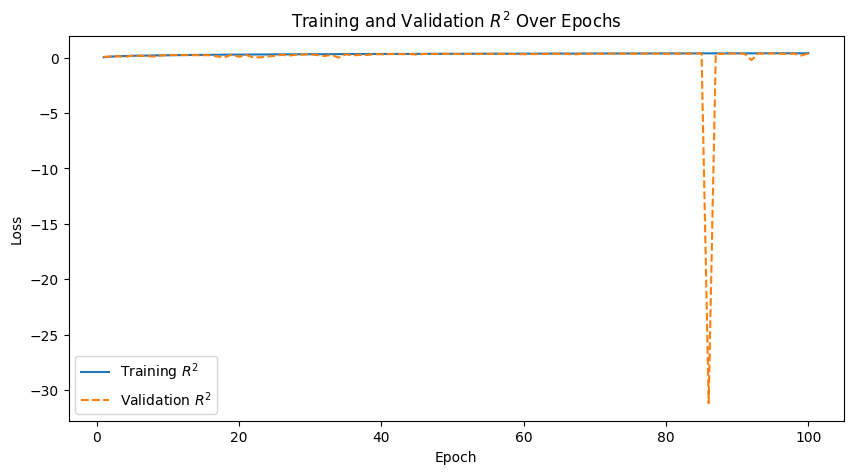

In [11]:
# 训练完成后，绘制训练和验证损失曲线
plot_save_path = '/data/coding/model_plot.png'
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), r2s_train, label='Training $R^2$')
plt.plot(range(1, num_epochs + 1), r2s_test, label='Validation $R^2$', linestyle='--')
# plt.text(1000, 0.5, 'R$^2$=0.9720', fontsize=14, va='center', ha='center')
plt.title('Training and Validation $R^2$ Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(plot_save_path)  # 保存图表到当前目录
plt.show()  # 显示图表

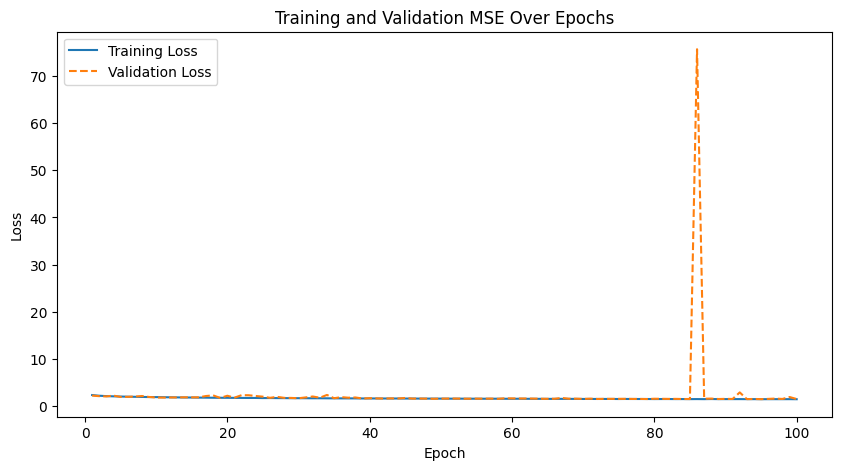

In [12]:
# 训练完成后，绘制训练和验证损失曲线
plot_save_path = '/data/coding/model_plot.png'
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss', linestyle='--')
# plt.text(1000, 0.03, 'MSE=0.0022', fontsize=14, va='center', ha='center')
plt.title('Training and Validation MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(plot_save_path)  # 保存图表到当前目录
plt.show()  # 显示图表